In [ ]:
!pip install meteostat

In [ ]:
# STEP 1: Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import os
from meteostat import Point, Hourly
from datetime import datetime, timedelta

In [ ]:
# STEP 2: Data Cleaning & Preprocessing
data = pd.read_csv("Dataset_Uber Traffic.csv")
print("Missing Values Before Cleaning:\n", data.isnull().sum())

Missing Values Before Cleaning:
 DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64


In [ ]:
data = data.drop_duplicates()

In [ ]:
data['DateTime'] = pd.to_datetime(data['DateTime'], format='%d/%m/%y %H:%M')

In [ ]:
data['Vehicles'] = data['Vehicles'].fillna(data['Vehicles'].mean())

In [ ]:
data_aggregated = (
    data.groupby(['Junction', pd.Grouper(key='DateTime', freq='h')])['Vehicles']
    .sum()
    .reset_index()
)

In [ ]:
scaler = MinMaxScaler()
data_aggregated['Vehicles_Normalized'] = scaler.fit_transform(data_aggregated[['Vehicles']])

In [ ]:
data_aggregated.to_csv("Cleaned_Uber_Traffic.csv", index=False)
print("Data Cleaning & Preprocessing Completed!\n")
print(data_aggregated.head())

Data Cleaning & Preprocessing Completed!

   Junction            DateTime  Vehicles  Vehicles_Normalized
0         1 2015-11-01 00:00:00        15             0.078212
1         1 2015-11-01 01:00:00        13             0.067039
2         1 2015-11-01 02:00:00        10             0.050279
3         1 2015-11-01 03:00:00         7             0.033520
4         1 2015-11-01 04:00:00         9             0.044693


In [ ]:
# STEP 3: Feature Engineering & Selection
data = pd.read_csv("Cleaned_Uber_Traffic.csv")
data['DateTime'] = pd.to_datetime(data['DateTime'])

In [ ]:
data['Hour'] = data['DateTime'].dt.hour
data['Day'] = data['DateTime'].dt.day
data['DayOfWeek'] = data['DateTime'].dt.dayofweek
data['Month'] = data['DateTime'].dt.month
data['IsWeekend'] = data['DayOfWeek'].isin([5, 6]).astype(int)

In [ ]:
data = data.sort_values(['Junction', 'DateTime'])
for lag in [1, 2, 3]:
    data[f'Vehicles_Lag_{lag}'] = data.groupby('Junction')['Vehicles'].shift(lag)

In [ ]:
data = data.dropna().reset_index(drop=True)

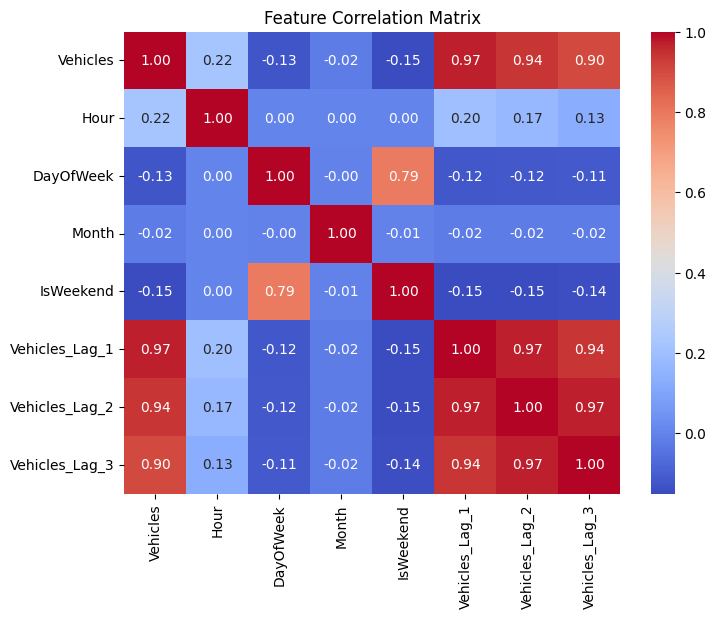

In [ ]:
corr_matrix = data[['Vehicles', 'Hour', 'DayOfWeek', 'Month', 'IsWeekend',
                    'Vehicles_Lag_1', 'Vehicles_Lag_2', 'Vehicles_Lag_3']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
X = data[['Hour', 'DayOfWeek', 'Month', 'IsWeekend',
          'Vehicles_Lag_1', 'Vehicles_Lag_2', 'Vehicles_Lag_3']]
y = data['Vehicles']

rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

RandomForestRegressor(random_state=42)

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [ ]:
print("\n Feature Engineering Completed Successfully!\n")
print("Feature Importance:\n", feature_importance)


 Feature Engineering Completed Successfully!

Feature Importance:
           Feature  Importance
4  Vehicles_Lag_1    0.944465
0            Hour    0.021030
5  Vehicles_Lag_2    0.011060
6  Vehicles_Lag_3    0.010891
2           Month    0.006658
1       DayOfWeek    0.004888
3       IsWeekend    0.001009



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



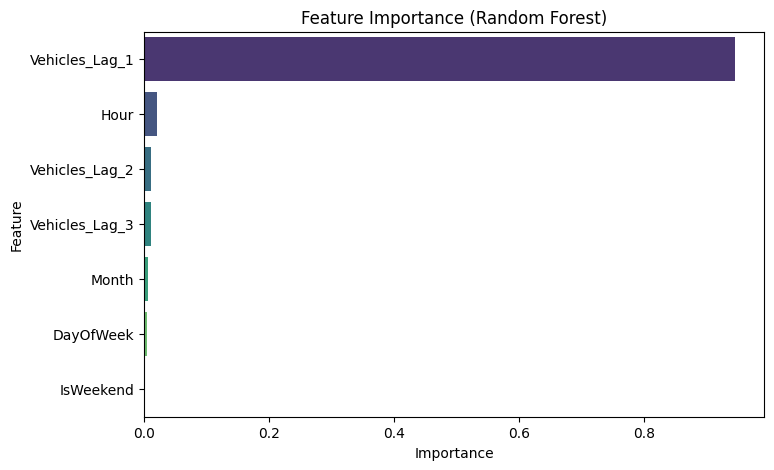

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title("Feature Importance (Random Forest)")
plt.show()

In [ ]:
data.to_csv("Engineered_Uber_Traffic.csv", index=False)

In [ ]:
# STEP 4: Data Collection & Integration
traffic = pd.read_csv("Engineered_Uber_Traffic.csv")
traffic['DateTime'] = pd.to_datetime(traffic['DateTime'])

In [ ]:
import requests

API_KEY = "cde372be06389b0955e7bc1d3fa63bf8"
CITY = "New Delhi"
BASE_URL = "https://api.openweathermap.org/data/2.5/weather"

# --- Fetch Weather Data Function ---
def fetch_weather(city, api_key):
    """
    Fetch current weather data from OpenWeather API.
    You can modify this function to use 'One Call API' for hourly data if available.
    """
    url = f"{BASE_URL}?q={city}&appid={api_key}&units=metric"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        weather_info = {
            'DateTime': datetime.now(),
            'temp': data['main']['temp'],
            'rhum': data['main']['humidity'],
            'wspd': data['wind']['speed'],
            'prcp': data.get('rain', {}).get('1h', 0.0)
        }
        return pd.DataFrame([weather_info])
    else:
        print(f" Failed to fetch weather data: {response.status_code}")
        print(response.json())
        return pd.DataFrame()

# --- Fetch Sample Weather Data for Date Range ---
print("\n🌦 Fetching weather data from OpenWeather API...")
weather_records = []


🌦 Fetching weather data from OpenWeather API...


In [ ]:
for date in traffic['DateTime'].dt.date.unique()[:5]:  # limit to 5 days for demo
    df = fetch_weather(CITY, API_KEY)
    df['DateTime'] = pd.to_datetime(date)
    weather_records.append(df)
    print(f" Weather fetched for {date}")

weather = pd.concat(weather_records, ignore_index=True)

 Weather fetched for 2015-11-01
 Weather fetched for 2015-11-02
 Weather fetched for 2015-11-03
 Weather fetched for 2015-11-04
 Weather fetched for 2015-11-05


In [ ]:
if not os.path.exists("events.csv"):
    print("\n⚠️ No events.csv found — creating dummy event data...\n")
    np.random.seed(42)
    dummy_dates = pd.date_range(
        start=traffic['DateTime'].min(),
        end=traffic['DateTime'].max(),
        freq='7D'
    )
    dummy_events = pd.DataFrame({
        'EventDateTime': dummy_dates,
        'EventType': np.random.choice(['Holiday', 'Concert', 'Sports'], len(dummy_dates))
    })
    dummy_events.to_csv("events.csv", index=False)
    print(" Dummy events.csv created with sample events.\n")

In [ ]:
def load_event_data(event_csv_path):
    events = pd.read_csv(event_csv_path)
    events['EventDateTime'] = pd.to_datetime(events['EventDateTime'])
    return events

events = load_event_data("events.csv")

In [ ]:
# Integrate All Data
def integrate_data(traffic_df, weather_df, events_df):
    merged = traffic_df.merge(
        weather_df,
        how='left',
        on='DateTime'
    )
    events_df['EventHour'] = events_df['EventDateTime'].dt.floor('h')
    event_hours = set(events_df['EventHour'])
    merged['IsEvent'] = merged['DateTime'].apply(lambda dt: 1 if dt.floor('h') in event_hours else 0)
    return merged

merged = integrate_data(traffic, weather, events)

In [ ]:
# Clean Integrated Data
def clean_integrated(df):
    df = df.drop_duplicates()
    weather_cols = ['temp', 'prcp', 'rhum', 'wspd']
    for col in weather_cols:
        if col in df.columns:
            df[col] = df[col].interpolate(method='linear')
    df = df.dropna(subset=['Vehicles'])
    return df

merged_clean = clean_integrated(merged)

In [ ]:
# Scale Features
def scale_features(df, cols_to_scale):
    scaler = StandardScaler()
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
    return df

cols_to_scale = ['temp', 'prcp', 'rhum', 'wspd']
merged_scaled = scale_features(merged_clean, cols_to_scale)

In [ ]:
merged_scaled.to_csv("Merged_Traffic_Weather_Event.csv", index=False)

print("\n Data Integration Completed Successfully!")
print("Final Dataset Shape:", merged_scaled.shape)
print(merged_scaled.head())


 Data Integration Completed Successfully!
Final Dataset Shape: (48108, 17)
   Junction            DateTime  Vehicles  Vehicles_Normalized  Hour  Day  \
0         1 2015-11-01 03:00:00         7             0.033520     3    1   
1         1 2015-11-01 04:00:00         9             0.044693     4    1   
2         1 2015-11-01 05:00:00         6             0.027933     5    1   
3         1 2015-11-01 06:00:00         9             0.044693     6    1   
4         1 2015-11-01 07:00:00         8             0.039106     7    1   

   DayOfWeek  Month  IsWeekend  Vehicles_Lag_1  Vehicles_Lag_2  \
0          6     11          1            10.0            13.0   
1          6     11          1             7.0            10.0   
2          6     11          1             9.0             7.0   
3          6     11          1             6.0             9.0   
4          6     11          1             9.0             6.0   

   Vehicles_Lag_3  temp  rhum  wspd  prcp  IsEvent  
0          

In [ ]:
# STEP 5: Model Development & Training
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load final merged dataset
data = pd.read_csv("Merged_Traffic_Weather_Event.csv")
data['DateTime'] = pd.to_datetime(data['DateTime'])
data = data.sort_values('DateTime').reset_index(drop=True)

# Features and target
target = 'Vehicles'
features = ['Hour','DayOfWeek','Month','IsWeekend','IsEvent',
            'Vehicles_Lag_1','Vehicles_Lag_2','Vehicles_Lag_3',
            'temp','prcp','rhum','wspd']

X = data[features]
y = data[target]

# Time-based train-validation split
split_index = int(len(data)*0.8)
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

print("Train shape:", X_train.shape, "Validation shape:", X_val.shape)

Train shape: (38486, 12) Validation shape: (9622, 12)


In [ ]:
X_train_filled = X_train.fillna(X_train.median())
X_val_filled = X_val.fillna(X_train.median())

In [ ]:
# Initialize Gradient Boosting
gbr = GradientBoostingRegressor(random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(gbr, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Train the model
grid.fit(X_train_filled, y_train)

# Best model and predictions
best_gbr = grid.best_estimator_
y_pred_gbr = best_gbr.predict(X_val_filled)

mae = mean_absolute_error(y_val, y_pred_gbr)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_gbr))
r2 = r2_score(y_val, y_pred_gbr)

print("\n Gradient Boosting Results")
print("Best Hyperparameters:", grid.best_params_)
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)


 Gradient Boosting Results
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
MAE: 3.3662828872795703
RMSE: 5.495816077405295
R2: 0.9592571463291762


In [ ]:
# ARIMA requires univariate series
train_series = y_train
val_series = y_val

# Fit ARIMA (p,d,q)
arima_model = sm.tsa.ARIMA(train_series, order=(5,1,0))
arima_result = arima_model.fit()

# Forecast
forecast = arima_result.forecast(steps=len(val_series))

# Evaluation
mae = mean_absolute_error(val_series, forecast)
rmse = np.sqrt(mean_squared_error(val_series, forecast))
r2 = r2_score(val_series, forecast)

print("\n ARIMA Results")
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)



 ARIMA Results
MAE: 20.135478239423268
RMSE: 27.372738930756537
R2: -0.01070304550927137


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Ensure no NaNs in data
X_train_scaled = np.nan_to_num(X_train_scaled)
X_val_scaled = np.nan_to_num(X_val_scaled)
y_train_scaled = np.nan_to_num(y_train_scaled)
y_val_scaled = np.nan_to_num(y_val_scaled)

# Create sequences for LSTM
def create_sequences(X, y, time_steps=3):
    X_seq, y_seq = [], []
    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

time_steps = 3
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, time_steps)

# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

history = lstm_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32,
                         validation_data=(X_val_seq, y_val_seq), verbose=1)

# Predict and inverse scale
y_pred_lstm_scaled = lstm_model.predict(X_val_seq)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled)
y_val_lstm = scaler_y.inverse_transform(y_val_seq)

# Evaluation
mae = mean_absolute_error(y_val_lstm, y_pred_lstm)
rmse = np.sqrt(mean_squared_error(y_val_lstm, y_pred_lstm))
r2 = r2_score(y_val_lstm, y_pred_lstm)

print("\n LSTM Results")
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Time-based CV results
tscv = TimeSeriesSplit(n_splits=5)
mae_scores, rmse_scores = [], []

for train_index, val_index in tscv.split(X):
    X_tr, X_vl = X.iloc[train_index], X.iloc[val_index]
    y_tr, y_vl = y.iloc[train_index], y.iloc[val_index]

    # Pipeline with imputer + Gradient Boosting
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('gbr', GradientBoostingRegressor(**grid.best_params_, random_state=42))
    ])

    pipeline.fit(X_tr, y_tr)
    y_pred = pipeline.predict(X_vl)

    mae_scores.append(mean_absolute_error(y_vl, y_pred))

    # Compute RMSE manually
    rmse = np.sqrt(mean_squared_error(y_vl, y_pred))
    rmse_scores.append(rmse)

print("\nTime-based CV results")
print("MAE:", np.mean(mae_scores))
print("RMSE:", np.mean(rmse_scores))




Time-based CV results
MAE: 3.0765739634001585
RMSE: 5.021557465010048


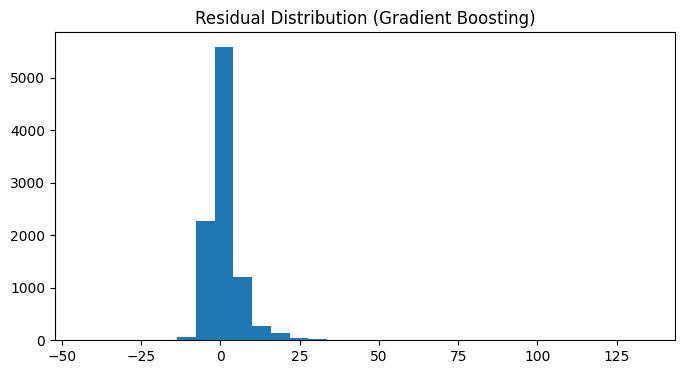

In [ ]:
import matplotlib.pyplot as plt

residuals = y_val - y_pred_gbr
plt.figure(figsize=(8,4))
plt.hist(residuals, bins=30)
plt.title("Residual Distribution (Gradient Boosting)")
plt.show()
